In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
tf.keras.backend.clear_session()

In [4]:
### import dataframe and use .describe
climate_data = pd.read_pickle("./merged_data1.pkl").set_index('Date')

climate_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Greenland,191.0,-2276.475916,1502.290154,-4995.83,-3608.490,-1910.49,-887.380,68.72
Antarctica,191.0,-990.202565,793.878126,-2809.24,-1636.200,-807.48,-260.570,63.31
Mean Sea Level,191.0,19.996283,20.193801,-12.73,3.425,13.94,35.485,63.00


In [5]:
# X will be a pandas dataframe of all columns except meantempm
#X = df[[col for col in df.columns if col != 'tempAvg']]
climate_data = climate_data.reset_index(drop=True)


X = climate_data[[col for col in climate_data.columns if col != 'Mean Sea Level']]

# y will be a pandas series of the meantempm
#y = df['tempAvg']


y = climate_data['Mean Sea Level']

In [6]:
# split data into training set and a temporary set using sklearn.model_selection.traing_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=23)

In [7]:
# take the remaining 20% of data in X_tmp, y_tmp and split them evenly
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

X_train.shape, X_test.shape, X_val.shape
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))

Training instances   152, Training features   2
Validation instances 20, Validation features 2
Testing instances    19, Testing features    2


In [8]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]

In [9]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model', loss_reduction=tf.keras.losses.Reduction.SUM)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7ef8737390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [11]:
evaluations = []
STEPS = 400
for i in range(100):
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluation = regressor.evaluate(input_fn=wx_input_fn(X_val, y_val,
                                                         num_epochs=1,
                                                         shuffle=False),
                                    steps=1)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:

In [12]:
evaluations[0]

{'average_loss': 53.816357,
 'label/mean': 15.476501,
 'loss': 1076.3271,
 'prediction/mean': 16.890339,
 'global_step': 120400}

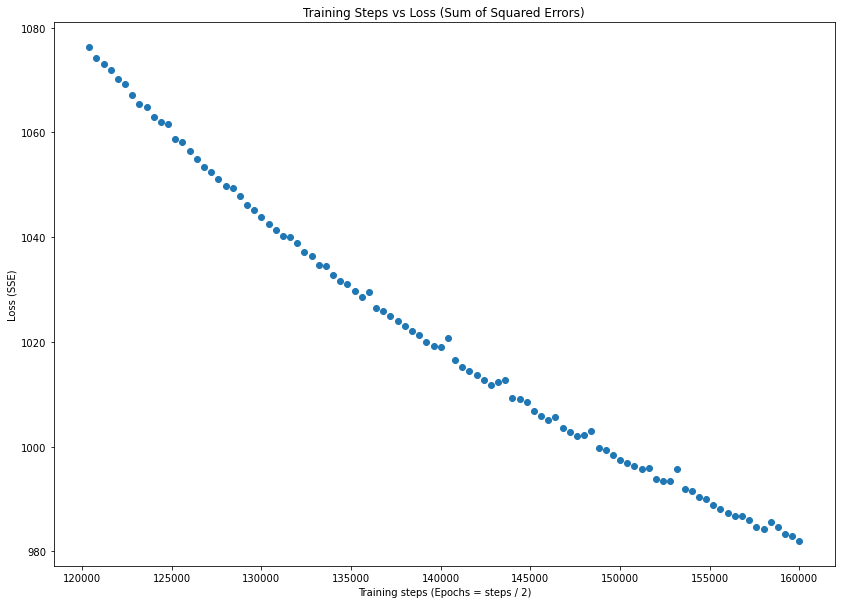

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 2)')
plt.ylabel('Loss (SSE)')
plt.title('Training Steps vs Loss (Sum of Squared Errors)')
plt.savefig('Loss_v_trainingsteps.png')
plt.show()

In [30]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

print("The Explained Variance: %.2f" % explained_variance_score(
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f millimeters" % mean_absolute_error(
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f millimeters" % median_absolute_error(
                                            y_test, predictions))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The Explained Variance: 0.95
The Mean Absolute Error: 4.41 milimeters
The Median Absolute Error: 4.01 millimeters


In [29]:
predictions

array([ 4.3410563,  2.106254 , 12.077033 ,  5.989097 , 55.97512  ,
       57.573143 , 11.6607275, 21.440208 , 32.599693 , -1.1282716,
       47.579033 , 26.828117 , 32.730797 ,  5.9902415, 12.211707 ,
       53.21804  , 29.893883 , 13.255103 , 41.985893 ], dtype=float32)

In [34]:
y_test

44     -0.15
14      1.38
72      8.10
47      1.98
180    53.05
189    62.93
76     12.67
107    16.75
154    40.97
10     -6.50
165    56.37
119    30.19
158    40.38
59      2.05
73     10.12
177    61.89
135    25.39
74     12.14
150    44.73
Name: Mean Sea Level, dtype: float64

In [4]:
plt.figure(1)
plt.style.use('ggplot')
plt.scatter(y_test, predictions)
plt.plot([predictions.min(), predictions.max()], [predictions.min(), predictions.max()], 'k--', lw=4)
plt.title('Sea Level Rise - Predicted vs Actual Values', fontsize=20)
plt.xlabel('Actual(mm)', fontsize=16)
plt.ylabel('Predicted(mm)', fontsize=16)
plt.savefig('predicted_vs_actual.png')
plt.show()

NameError: name 'y_test' is not defined

<Figure size 1008x720 with 0 Axes>

,Greenland,Antarctica
44,-777.31,-183.86
14,-391.86,-131.12
72,-1472.45,-652.03
47,-803.83,-49.30
180,-4766.12,-2703.56
189,-4928.78,-2542.18
76,-1610.79,-520.67
107,-2705.75,-927.16
154,-3874.66,-1655.45
10,-45.85,-43.52
